In [31]:
import pandas as pd
import numpy as np
from datetime import datetime
import pytz
import re

# 1. Function to convert epoch to a CST datetime object
def convert_epoch_to_cst_datetime(epoch, cst):
    utc_time = datetime.utcfromtimestamp(epoch).replace(tzinfo=pytz.utc)
    return utc_time.astimezone(cst)

# 2. Function to create 'submitInterval' column based on time of day
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

# 3. Function to read CSV file
def read_csv(file_path):
    return pd.read_csv(file_path)

# 4. Function to convert 'submitTime', 'startTime', and 'endTime' to CST
def convert_time_columns(df, cst):
    df['submitTime'] = df['submitTime'].apply(lambda x: convert_epoch_to_cst_datetime(x, cst))
    df['startTime'] = df['startTime'].apply(lambda x: convert_epoch_to_cst_datetime(x, cst))
    df['endTime'] = df['endTime'].apply(lambda x: convert_epoch_to_cst_datetime(x, cst))
    return df

# 5. Function to calculate 'pendTime'
def calculate_pend_time(df):
    df['pendTime'] = (df['startTime'] - df['submitTime']).dt.total_seconds()
    return df

# 6. Function to add 'submitInterval' and 'submitDay' columns
def add_time_of_day_and_day(df):
    df['submitInterval'] = df['submitTime'].dt.hour.apply(get_time_of_day)
    df['submitDay'] = df['submitTime'].dt.day_name()
    return df

# 7. Function to overwrite 'queue' after replacing 'rhel8_' and 'rhel88_'
def overwrite_queue(df):
    df['queue'] = df['queue'].str.replace(r'rhel8_', '', regex=True)
    df['queue'] = df['queue'].str.replace(r'rhel88_', '', regex=True)
    return df

# 8. Function to extract memory from 'resReq' and overwrite existing values
def extract_requested_memory(df):
    df['resReq'] = df['resReq'].astype(str)
    df['requested_memory'] = df['resReq'].apply(lambda resReq: float(re.search(r'mem=(\d+(\.\d+)?)', resReq).group(1)) if re.search(r'mem=(\d+(\.\d+)?)', resReq) else None)
    return df.dropna(subset=['requested_memory'])

# 9. Function to convert 'maxRMem' from KB to MB
def convert_max_rmem(df):
    df['maxRMem'] = df['maxRMem'] / 1024
    return df

# 10. Function to create the 'userCancelJob' indicator variable
def create_user_cancel_job(df):
    df['userCancelJob'] = np.where(df['pendTime'] < 0, 1, 0)
    return df

# 11. Function to filter rows where 'userCancelJob' is greater than 0
def remove_user_cancel_job(df):
    return df[df['userCancelJob'] == 0]

# 12. Function to order the 'queue' variable based on value counts
def order_queue_by_value_counts(df):
    queue_counts = df['queue'].value_counts()
    ordered_queues = queue_counts.index
    df['queue'] = pd.Categorical(df['queue'], categories=ordered_queues, ordered=True)
    return df

# 13. Main preprocessing function
def preprocess_csv(file_path):
    cst = pytz.timezone('US/Central')  # Define CST timezone
    
    # Step-by-step preprocessing
    df = read_csv(file_path)
    df = convert_time_columns(df, cst)
    df = calculate_pend_time(df)
    df = add_time_of_day_and_day(df)
    df = overwrite_queue(df)
    df = extract_requested_memory(df)
    df = convert_max_rmem(df)
    df = create_user_cancel_job(df)
    df = remove_user_cancel_job(df)  # Keep only rows where userCancelJob > 0
    df = order_queue_by_value_counts(df)  # Order the 'queue' column by value counts
    
    # Display the filtered dataframe
    #print(df.head())
    #print(df.shape[0])
    
    return df


   userId      jobId  jobIdx  numProcessors jStatus  \
0   69430  233656568       0              4    exit   
1  107357  233656570       0              4    done   
2  107357  233656569       0              4    done   
3  107357  233656571       0              4    done   
4  107357  233656572       0              4    done   

                  submitTime                  startTime  \
0  2024-08-19 00:01:34-05:00  2024-08-19 00:01:39-05:00   
1  2024-08-19 00:04:52-05:00  2024-08-19 00:04:54-05:00   
2  2024-08-19 00:04:52-05:00  2024-08-19 00:04:54-05:00   
3  2024-08-19 00:04:52-05:00  2024-08-19 00:04:54-05:00   
4  2024-08-19 00:04:53-05:00  2024-08-19 00:04:54-05:00   

                     endTime   queue                              resReq  ...  \
0  2024-08-19 00:08:45-05:00  cryoem                   rusage[mem=20000]  ...   
1  2024-08-19 09:43:11-05:00     gpu  rusage[mem=24576.00] span[ptile=4]  ...   
2  2024-08-19 09:45:44-05:00     gpu  rusage[mem=24576.00] span[ptile=4

In [ ]:
# Example usage:
file_path = '../common/finished_jobs_1_week.csv'
df_preprocessed = preprocess_csv(file_path)
##print(df_preprocessed.head())

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV file into a pandas DataFrame
file_path = '../common/processed_finished_jobs.csv'
df = pd.read_csv(file_path)
df = df[df['userCancelJob'] == 0]


queue_counts = df['queue_rename'].value_counts()
sorted_queues = queue_counts.index

# Step 2: Reorder DataFrame based on the sorted queue order
df['queue_rename'] = pd.Categorical(df['queue_rename'], categories=sorted_queues, ordered=True)

# Reorder DataFrame
df_sorted = df.copy()
df_sorted['queue_rename'] = df_sorted['queue_rename'].cat.reorder_categories(sorted_queues)

# Example preprocessing
# Convert categorical variables to numeric if needed
df_sorted['queue_rename_encoded'] = df_sorted['queue_rename'].astype('category').cat.codes
df_sorted['submitDay_encoded'] = df_sorted['submitDay'].astype('category').cat.codes
df_sorted['submitInterval_encoded'] = df_sorted['submitInterval'].astype('category').cat.codes


# Select the relevant columns

columns_of_interest = [
    'runTime', 'numProcessors', 'jStatus', 'queue_rename_encoded', 
    'requested_memory', 'pendTime', 'submitDay_encoded', 'submitInterval_encoded', 
    'maxRMem_MB'
]

df_subset = df_sorted[columns_of_interest]

print(df_sorted.head())



/tmp/ipykernel_273417/3150408657.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_subset.corr()


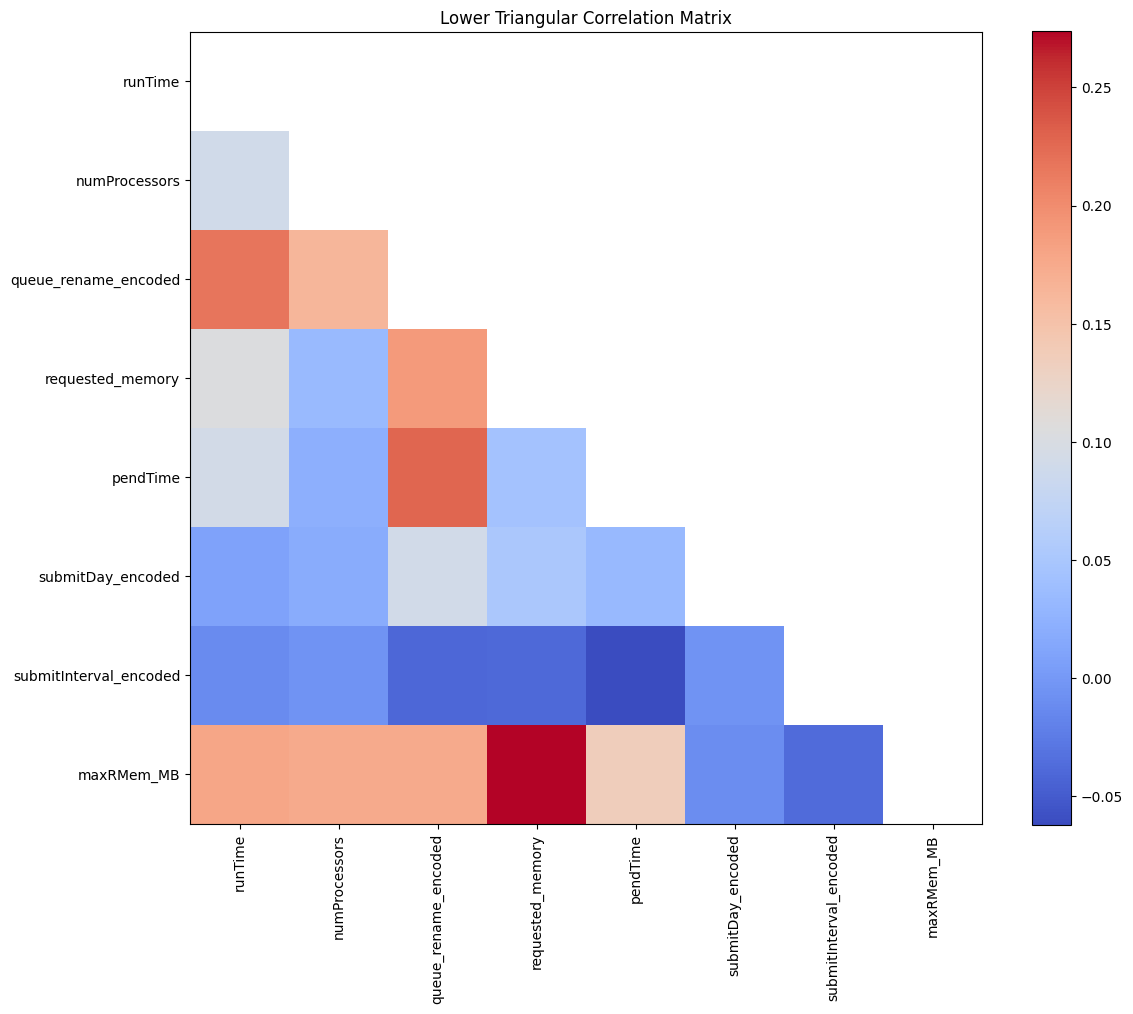

In [28]:
# Calculate correlations
correlation_matrix = df_subset.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the heatmap using matplotlib, masking the upper triangle
plt.figure(figsize=(12, 10))

# Mask the upper triangle by applying the mask to the data
masked_corr = np.ma.masked_where(mask, correlation_matrix)

# Use imshow to plot the lower triangular part only
plt.imshow(masked_corr, cmap='coolwarm', interpolation='none')
plt.colorbar()

# Add labels
plt.xticks(np.arange(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(np.arange(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Lower Triangular Correlation Matrix')

# Show the plot
plt.tight_layout()
plt.savefig('lower_triangular_correlation_matrix.png')
plt.show()

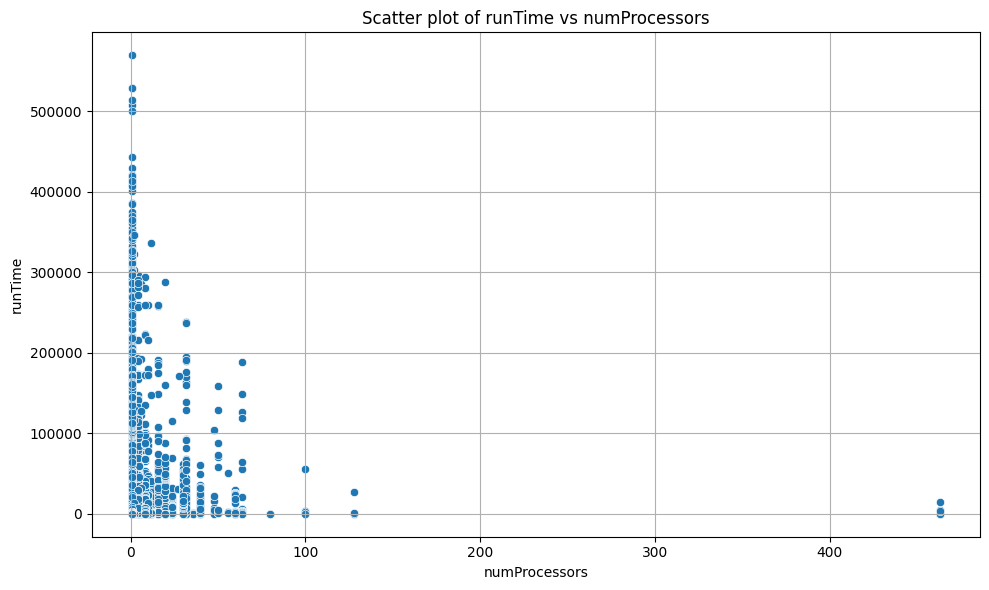

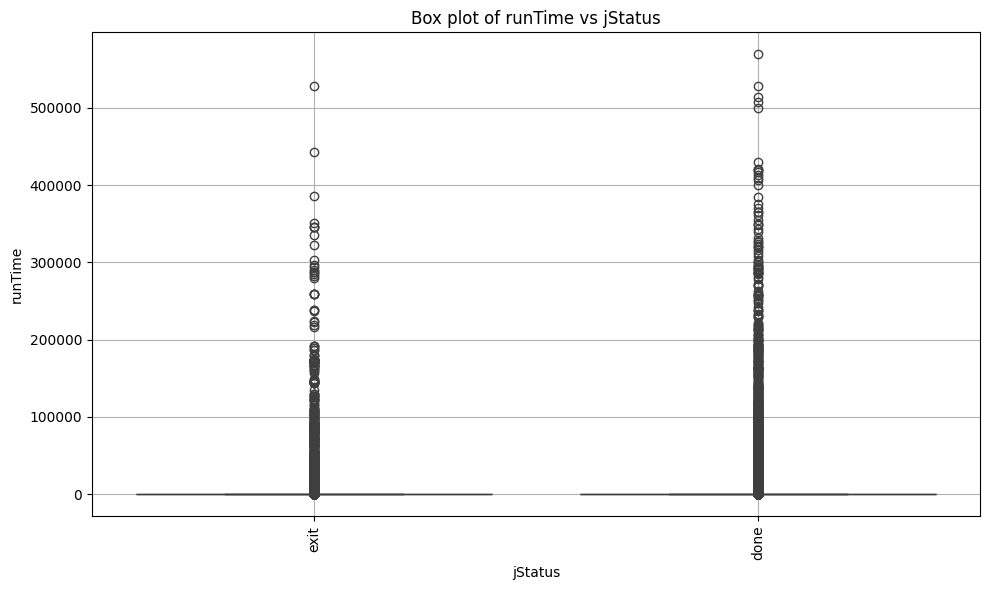

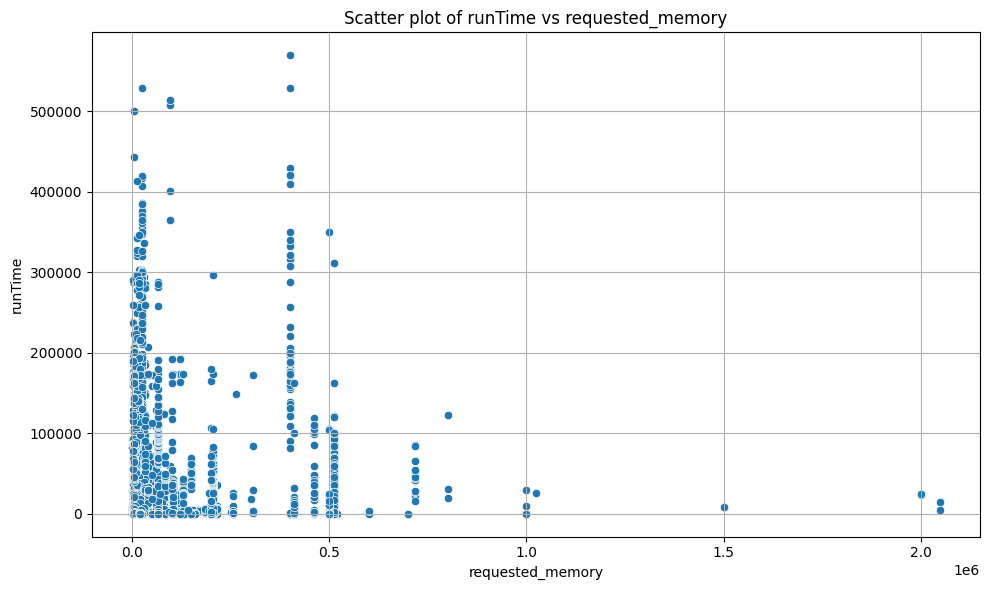

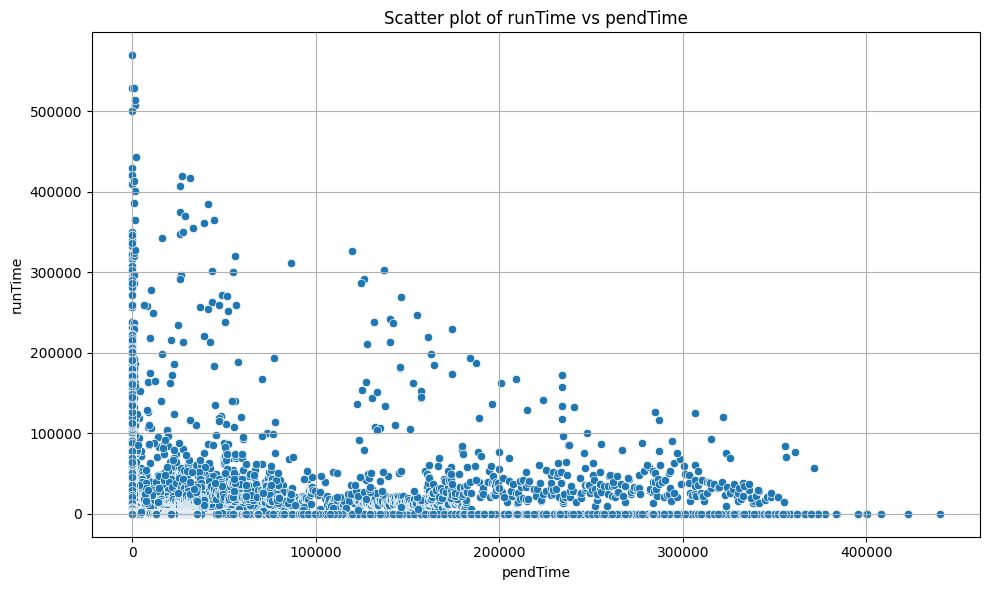

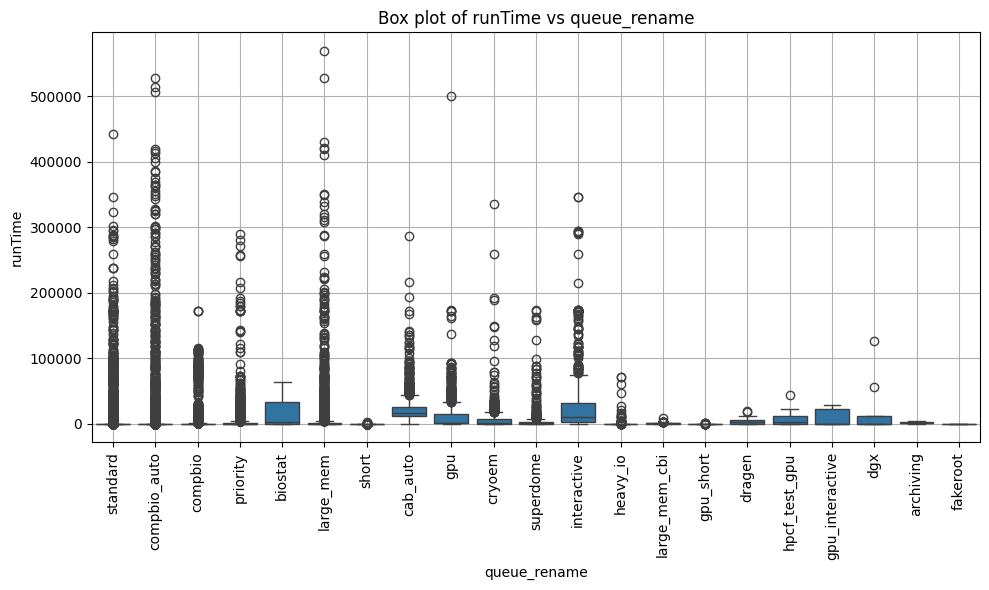

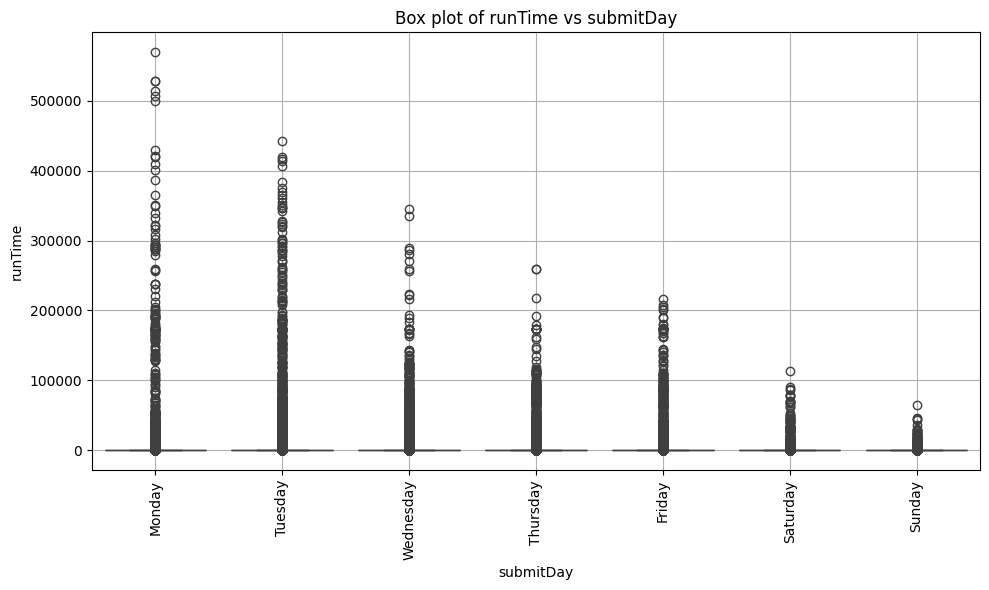

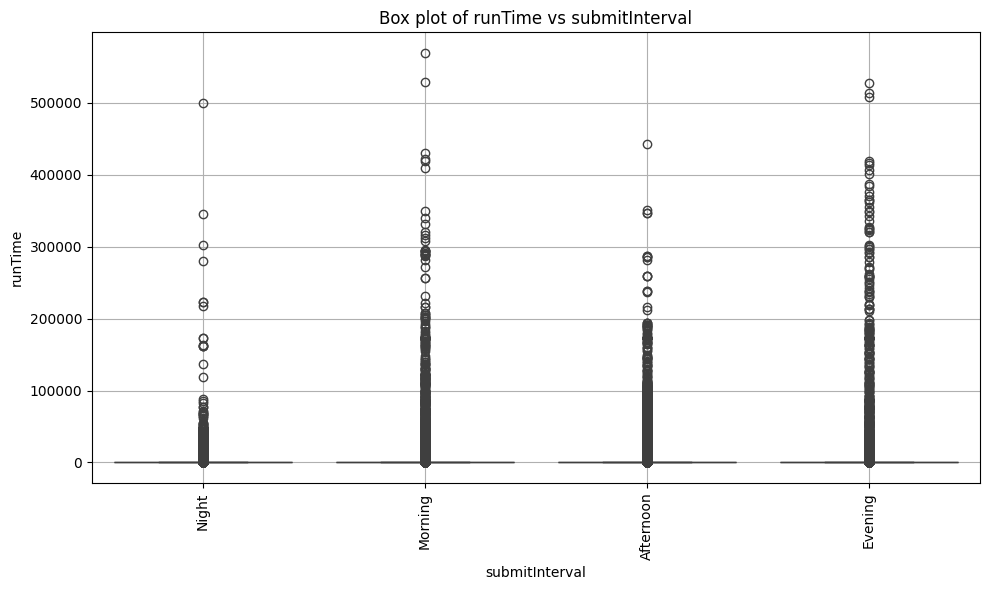

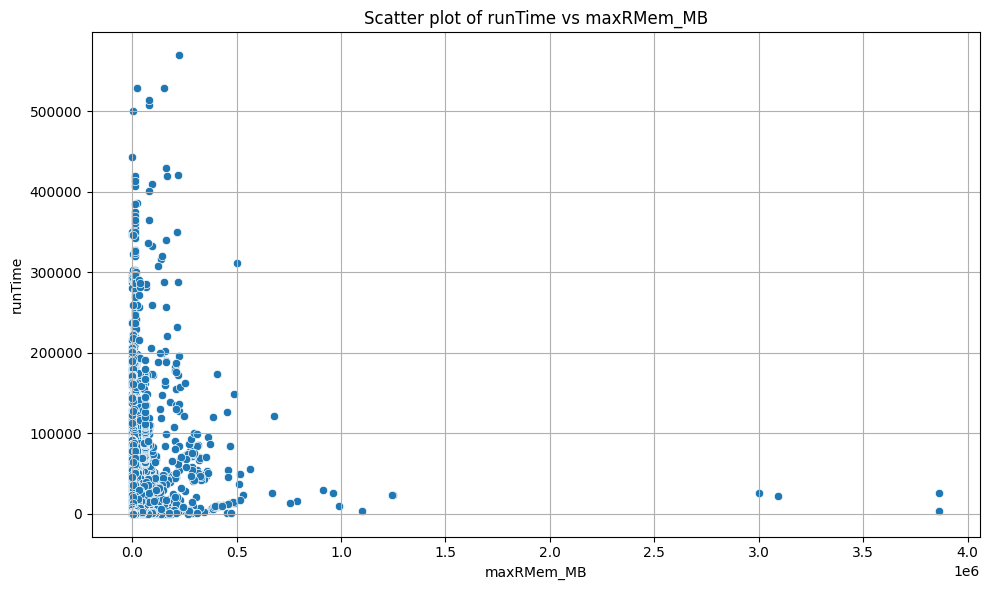

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define columns of interest, excluding 'runTime'
vars_of_interest = [
    'runTime', 'numProcessors', 'jStatus', 
    'requested_memory', 'pendTime', 'queue_rename', 'submitDay', 'submitInterval', 
    'maxRMem_MB'
]

corr_of_interest = [col for col in vars_of_interest if col != 'runTime']

# Create scatter plots and box plots
for var in corr_of_interest:
    if var in df_sorted.columns:  # Check if the column exists in the DataFrame
        plt.figure(figsize=(10, 6))

        # Check if the variable is categorical
        if pd.api.types.is_categorical_dtype(df_sorted[var]) or df_sorted[var].dtype == 'object':
            # Box plot for categorical variables
            sns.boxplot(x=df_sorted[var], y=df_sorted['runTime'])
            plt.xlabel(var)
            plt.ylabel('runTime')
            plt.title(f'Box plot of runTime vs {var}')
            plt.xticks(rotation=90)
            plt.grid(True)

        # Scatter plot for numeric variables
        elif pd.api.types.is_numeric_dtype(df_sorted[var]):
            sns.scatterplot(x=df_sorted[var], y=df_sorted['runTime'])
            plt.xlabel(var)
            plt.ylabel('runTime')
            plt.title(f'Scatter plot of runTime vs {var}')
            plt.grid(True)

        plt.tight_layout()
        plt.show()
    else:
        print(f"Column '{var}' not found in the DataFrame.")


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

df_subset = df_sorted[columns_of_interest]
print(df_subset.head())
# Separate the response variable (runTime) and predictors (covariates)
X = df_subset.drop('runTime', axis=1)
y = df_subset['runTime']

# One-hot encode the categorical variables ('queue_rename' and 'jStatus')
X_encoded = pd.get_dummies(X, columns=['queue_rename_encoded', 'submitDay_encoded', 'submitInterval_encoded', 'jStatus'], drop_first=True)

# Split the data into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Print the model coefficients
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


   runTime  numProcessors jStatus  queue_rename_encoded  requested_memory  \
0      426              4    exit                     9           20000.0   
1    34697              4    done                     8           24576.0   
2    34850              4    done                     8           24576.0   
3    35888              4    done                     8           24576.0   
4    34749              4    done                     8           24576.0   

   pendTime  submitDay_encoded  submitInterval_encoded  maxRMem_MB  
0       5.0                  1                       3      2203.0  
1       2.0                  1                       3       315.0  
2       2.0                  1                       3       326.0  
3       2.0                  1                       3       322.0  
4       1.0                  1                       3       315.0  
Coefficients: [ 9.20105980e+01  4.73200842e-03  5.80775084e-07  7.55119238e-02
 -1.91293504e+02  1.26387927e+03  1.39321652

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

df_subset = df_sorted[columns_of_interest]
print(df_subset.head())
# Separate the response variable (runTime) and predictors (covariates)
X = df_subset.drop('pendTime', axis=1)
y = df_subset['pendTime']

# One-hot encode the categorical variables ('queue_rename' and 'jStatus')
X_encoded = pd.get_dummies(X, columns=['queue_rename_encoded', 'submitDay_encoded', 'submitInterval_encoded', 'jStatus'], drop_first=True)

# Split the data into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Print the model coefficients
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


   runTime  numProcessors jStatus  queue_rename_encoded  requested_memory  \
0      426              4    exit                     9           20000.0   
1    34697              4    done                     8           24576.0   
2    34850              4    done                     8           24576.0   
3    35888              4    done                     8           24576.0   
4    34749              4    done                     8           24576.0   

   pendTime  submitDay_encoded  submitInterval_encoded  maxRMem_MB  
0       5.0                  1                       3      2203.0  
1       2.0                  1                       3       315.0  
2       2.0                  1                       3       326.0  
3       2.0                  1                       3       322.0  
4       1.0                  1                       3       315.0  
Coefficients: [ 6.31654767e+02 -1.17535394e+07  9.50498520e+01  1.13782205e+03
  3.95537677e+07  3.05214070e+07 -1.56420434